In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import requests
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
import re
from tqdm import tqdm
import time

# Load environment variables
load_dotenv()

# Together API endpoint and key
endpoint = 'https://api.together.xyz/inference'
TOGETHER_API_KEY = os.getenv('TOGETHER_API_KEY')

# Codebook for contrarian claims
CODEBOOK = """
1.1: Ice/permafrost/snow cover isn't melting
1.2: We're heading into an ice age/global cooling
1.3: Weather is cold/snowing
1.4: Climate hasn't warmed/changed over the last (few) decade(s)
1.5: Oceans are cooling/not warming
1.6: Sea level rise is exaggerated/not accelerating
1.7: Extreme weather isn't increasing/has happened before/isn't linked to climate change
1.8: They changed the name from 'global warming' to 'climate change'
2.1: It's natural cycles/variation
2.2: It's non-greenhouse gas human climate forcings (aerosols, land use)
2.3: There's no evidence for greenhouse effect/carbon dioxide driving climate change
2.4: CO2 is not rising/ocean pH is not falling
2.5: Human CO2 emissions are miniscule/not raising atmospheric CO2
3.1: Climate sensitivity is low/negative feedbacks reduce warming
3.2: Species/plants/reefs aren't showing climate impacts yet/are benefiting from climate change
3.3: CO2 is beneficial/not a pollutant
3.4: It's only a few degrees (or less)
3.5: Climate change does not contribute to human conflict/threaten national security
3.6: Climate change doesn't negatively impact health
4.1: Climate policies (mitigation or adaptation) are harmful
4.2: Climate policies are ineffective/flawed
4.3: It's too hard to solve
4.4: Clean energy technology/biofuels won't work
4.5: People need energy (e.g., from fossil fuels/nuclear)
5.1: Climate-related science is uncertain/unsound/unreliable
5.2: Climate movement is alarmist/wrong/political/biased/hypocritical
5.3: Climate change (science or policy) is a conspiracy
0.0: None of the above
"""

def prepare_prompt(text):
    """Prepare prompt with chain of thought and decomposition for Llama 3.3."""
    prompt = f"""[INST] Analyze this climate change text by following these steps:

1. First, identify the main claim being made about climate change.
2. Then, identify any evidence or support provided for this claim.
3. Compare the claim and evidence against each category in the codebook.
4. Select the most appropriate code based on this analysis.

Please output your analysis in this format:
1. Main claim:
2. Evidence/Support:
3. Analysis of potential categories:
4. Final classification:
   Code: [write exactly one code number]
   Reason: [explain in one sentence why this code best matches]

Text to analyze:
{text}

Available codes:
{CODEBOOK}
[/INST]"""
    return prompt

def classify_text(text, retry_count=3, retry_delay=1):
    """Classify text with retry logic and rate limiting."""
    for attempt in range(retry_count):
        try:
            headers = {
                "Authorization": f"Bearer {TOGETHER_API_KEY}",
                "Content-Type": "application/json"
            }
            
            data = {
                "model": "meta-llama/Llama-3.3-70B-Instruct-Turbo",
                "prompt": prepare_prompt(text),
                "max_tokens": 600,
                "temperature": 0.3,  # Keeping temperature low for consistency
                "top_p": 0.9,
                "top_k": 40,
                "repetition_penalty": 1.0
            }
            
            response = requests.post(endpoint, json=data, headers=headers)
            
            if response.status_code != 200:
                print(f"Attempt {attempt + 1}: API error {response.status_code}")
                print(f"Error details: {response.text}")
                if attempt == retry_count - 1:
                    return "0.0", f"API request failed: {response.status_code} - {response.text}"
                time.sleep(retry_delay * (attempt + 1))
                continue
            
            response_data = response.json()
            
            if 'output' in response_data:
                if isinstance(response_data['output'], dict):
                    output = response_data['output'].get('choices', [{}])[0].get('text', '')
                else:
                    output = response_data['output']
            else:
                print(f"Unexpected response format: {response_data}")
                return "0.0", "Unexpected API response format"
            
            print(f"\nRaw output: {output[:200]}...")  # Print first 200 chars for debugging
            
            if not output or len(output.strip()) == 0:
                if attempt < retry_count - 1:
                    print("Empty response, retrying...")
                    time.sleep(retry_delay * (attempt + 1))
                    continue
                else:
                    return "0.0", "Empty response from API after all retries"
                    
            # Clean up the output by removing any markdown formatting
            output = re.sub(r'##\s*Step \d+:', '', output)  # Remove step headers
            output = re.sub(r'\*\*.*?\*\*', '', output)  # Remove bold text
            
            # Enhanced patterns for code extraction
            code_patterns = [
                r'(?:^|\n)(?:2\.|Code:)\s*([0-9]+\.[0-9]+|0\.0)',  # Matches numbered list format or "Code:"
                r'code chosen is\s*([0-9]+\.[0-9]+|0\.0)',  # Matches descriptive format
                r'(?:selected|appropriate|matching|category)\s*(?:code|is)?\s*(?:is|:)?\s*([0-9]+\.[0-9]+|0\.0)',  # Matches alternative formats
                r'\b([0-9]+\.[0-9]+|0\.0)\b'  # Last resort - any valid code format
            ]
            
            code = "0.0"  # Default code
            for pattern in code_patterns:
                match = re.search(pattern, output, re.IGNORECASE)
                if match:
                    code = match.group(1).strip()
                    break
            
            # Enhanced patterns for reasoning extraction
            reasoning_patterns = [
                r'(?:^|\n)(?:3\.|Reason:)\s*([^[]+?)(?=\n|$)',  # Matches numbered list or "Reason:" format
                r'because\s*([^[]+?)(?=\n|$)',  # Matches "because" format
                r'(?:Main claim and evidence in the text:|Analysis:)\s*([^[]+?)(?=\n|2\.|Code:|$)',  # Fallback to main claim
                r'(?<=\n)([^[]+?)(?=\n|$)'  # Last resort - last non-empty line
            ]
            
            reasoning = "No reasoning provided"
            for pattern in reasoning_patterns:
                match = re.search(pattern, output, re.IGNORECASE)
                if match:
                    reasoning = match.group(1).strip()
                    break
            
            # Validate code format
            if not re.match(r'^[0-5]\.[0-3]$|^0\.0$', code):
                print(f"Invalid code format detected: {code}")
                code = "0.0"
            
            return code, reasoning
                
        except requests.exceptions.RequestException as e:
            if attempt == retry_count - 1:
                return "0.0", f"API request failed after {retry_count} attempts: {str(e)}"
            time.sleep(retry_delay * (attempt + 1))
            continue
            
        except Exception as e:
            return "0.0", f"Processing failed: {str(e)}"

def process_dataframe(df, batch_size=100, save_interval=500):
    """Process the entire dataframe with progress tracking and periodic saving."""
    df_processed = df.copy()
    
    # Initialize or clean columns
    df_processed['model_prediction'] = df_processed.get('model_prediction', None)
    df_processed['reasoning'] = df_processed.get('reasoning', None)
    
    # Get unprocessed rows
    unprocessed_mask = df_processed['model_prediction'].isna()
    total_unprocessed = unprocessed_mask.sum()
    
    if total_unprocessed == 0:
        print("All rows have already been processed!")
        return df_processed
    
    print(f"Processing {total_unprocessed} unprocessed rows...")
    
    success_count = 0
    error_count = 0
    
    with tqdm(total=total_unprocessed) as pbar:
        for idx in df_processed[unprocessed_mask].index:
            try:
                text = str(df_processed.loc[idx, 'text'])
                
                if text.lower() in ['nan', 'none', ''] or len(text.strip()) < 10:
                    df_processed.loc[idx, 'model_prediction'] = "0.0"
                    df_processed.loc[idx, 'reasoning'] = "Text too short or empty"
                    success_count += 1
                else:
                    code, reasoning = classify_text(text)
                    df_processed.loc[idx, 'model_prediction'] = code
                    df_processed.loc[idx, 'reasoning'] = reasoning
                    
                    # Consider it a success if we got any valid code (including 0.0)
                    if code in ["0.0", "1.1", "1.2", "1.3", "1.4", "1.5", "1.6", "1.7", "1.8", 
                              "2.1", "2.2", "2.3", "2.4", "2.5", "3.1", "3.2", "3.3", "3.4", 
                              "3.5", "3.6", "4.1", "4.2", "4.3", "4.4", "4.5", "5.1", "5.2", "5.3"]:
                        success_count += 1
                    else:
                        error_count += 1
                        print(f"Error in row {idx}: Invalid code {code}")
                
                pbar.update(1)
                
                if (success_count + error_count) % save_interval == 0:
                    print(f"\nSaving intermediate results...")
                    df_processed.to_csv('intermediate_results_contrarian.csv', index=False)
                
                if (success_count + error_count) % batch_size == 0:
                    time.sleep(1)
                    
            except Exception as e:
                print(f"\nError processing row {idx}: {str(e)}")
                df_processed.loc[idx, 'model_prediction'] = "0.0"
                df_processed.loc[idx, 'reasoning'] = f"Processing failed: {str(e)}"
                error_count += 1
                continue
    
    print(f"\nProcessing complete!")
    print(f"Successfully processed: {success_count} rows")
    print(f"Errors: {error_count} rows")
    
    return df_processed

def load_data(filepath):
    """Load and prepare the dataset."""
    try:
        df = pd.read_csv(filepath, dtype={
            'text_id': 'Int64',
            'text': str,
            'original_code': float,
            'replicated_code': float,
            'model_code': float,
            'reason': str
        })
        
        df['text'] = df['text'].fillna('').astype(str)
        return df
        
    except Exception as e:
        print(f"Error loading data: {str(e)}")
        return None

# Main execution
if __name__ == "__main__":
    df = load_data('Data/contrarian_claims_reasons.csv')
    if df is not None:
        df_results = process_dataframe(df)
        #df_results.to_csv('final_results_contrarian.csv', index=False)

In [14]:
df_results['model_prediction'].value_counts()

model_prediction
0.0    40
5.1    16
5.2    15
4.1     9
2.1     6
2.3     3
1.1     3
3.2     2
3.3     2
4.2     2
3.1     1
0.1     1
Name: count, dtype: int64

In [10]:
df_results['model_prediction'].value_counts()

model_prediction
0.0    7
5.2    5
5.1    4
2.3    2
4.1    1
3.2    1
Name: count, dtype: int64

In [20]:
df_results = pd.read_csv('results_csvs/climate_llama_33.csv')

In [18]:
results

,text_id,text,original_code,replicated_code,model_code,reason,model_prediction,reasoning
0,0,The Food and Drug Administrations seeks input ...,0.0,0.0,0.0,0.0 - This text is not related to climate chan...,0.0,Analysis of potential categories: This text do...
1,1,Has the globe warmed? Most think that since th...,5.1,5.1,5.1,Reasoning: The text questions the reliability ...,5.1,Analysis of potential categories: The text doe...
2,2,The Heartland Institute is a 27-year-old natio...,0.0,0.0,0.0,Reasoning: The text does not contain any state...,0.0,Analysis of potential categories: Since the te...
3,3,Interesting facts were revealed in this articl...,0.0,0.0,0.0,The text is not related to climate change or a...,0.0,Analysis of potential categories: Since the te...
4,4,"""The government is mobilized to find the truth...",0.0,5.3,0.0,0.0 - This text does not relate to any of the ...,0.0,Analysis of potential categories: Upon examini...
...,...,...,...,...,...,...,...,...
95,95,How do theyattributethe heatwave to global war...,5.1,5.1,5.1,The statement questions the attribution of a h...,5.1,Analysis of potential categories: This claim s...
96,96,It's remarkable that she doesn't even dare to ...,0.0,5.1,5.2,Reasoning: The text is criticizing a female re...,5.3,Analysis of potential categories:
97,97,"We now know that the progressives, despite the...",0.0,0.0,0.0,The text does not mention anything related to ...,0.0,Analysis of potential categories:
98,98,"Yes, and it was getting warmer when the First ...",0.0,2.1,1.3,1.3 - The text mentions cold weather and snowi...,0.0,Analysis of potential categories: The claim an...


Distribution of codes:

Original Code:
original_code
0.0    57
1.1     3
1.2     1
1.6     1
1.7     2
2.1     6
2.3     3
3.1     2
3.3     3
4.1     5
4.2     1
5.1    10
5.2     6
Name: count, dtype: int64

Replicated Code:
replicated_code
0.0    48
1.0     6
1.1     3
1.2     1
1.3     1
1.6     1
2.1     7
2.3     2
3.3     3
4.1     5
4.2     2
4.3     2
4.4     1
4.5     1
5.1    12
5.2     3
5.3     2
Name: count, dtype: int64

Model Code:
model_code
0.0    36
1.1     7
1.3     1
1.4     2
1.6     1
1.7     2
2.1     8
2.3     9
2.5     2
3.3     3
4.1     4
4.2     3
4.4     1
4.5     2
5.1    10
5.2     9
Name: count, dtype: int64

LLM Prediction:
model_prediction
0.0    40
0.1     1
1.1     3
2.1     6
2.3     3
3.1     1
3.2     2
3.3     2
4.1     9
4.2     2
5.1    16
5.2    15
Name: count, dtype: int64

Agreement Percentages:
Original vs Replicated: 66.0%
Original vs Model: 61.0%
Original vs LLM Prediction: 63.0%


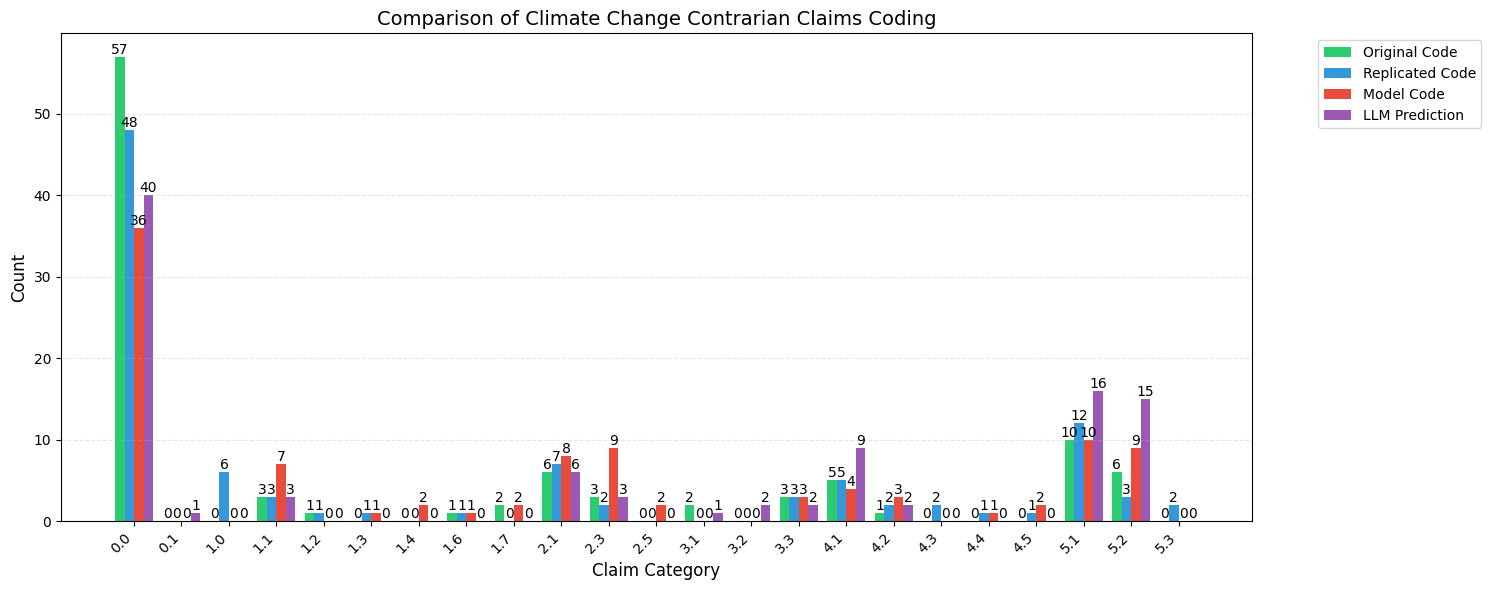

In [15]:
import matplotlib.pyplot as plt
import numpy as np

def plot_code_comparison(df_results):
    """
    Create a bar plot comparing distributions across different codings.
    """
    # Convert all codes to strings for consistency
    df_temp = df_results.copy()
    df_temp['original_code'] = df_temp['original_code'].astype(str)
    df_temp['replicated_code'] = df_temp['replicated_code'].astype(str)
    df_temp['model_code'] = df_temp['model_code'].astype(str)
    
    # Get all unique categories across all columns
    categories = sorted(set(df_temp['original_code']) | 
                       set(df_temp['replicated_code']) | 
                       set(df_temp['model_code']) | 
                       set(df_temp['model_prediction']))
    
    # Get value counts for each column, reindex to include all categories
    original_counts = df_temp['original_code'].value_counts().reindex(categories).fillna(0)
    replicated_counts = df_temp['replicated_code'].value_counts().reindex(categories).fillna(0)
    model_counts = df_temp['model_code'].value_counts().reindex(categories).fillna(0)
    prediction_counts = df_temp['model_prediction'].value_counts().reindex(categories).fillna(0)
    
    # Number of categories and set up plot
    n = len(categories)
    x = np.arange(n)
    width = 0.2  # Width of the bars
    
    # Create plot
    plt.figure(figsize=(15, 6))
    
    # Create bars
    b1 = plt.bar(x - 1.5*width, original_counts, width, label='Original Code', color='#2ecc71')
    b2 = plt.bar(x - 0.5*width, replicated_counts, width, label='Replicated Code', color='#3498db')
    b3 = plt.bar(x + 0.5*width, model_counts, width, label='Model Code', color='#e74c3c')
    b4 = plt.bar(x + 1.5*width, prediction_counts, width, label='LLM Prediction', color='#9b59b6')
    
    # Customize plot
    plt.xlabel('Claim Category', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.title('Comparison of Climate Change Contrarian Claims Coding', fontsize=14)
    plt.xticks(x, categories, rotation=45, ha='right')
    
    # Add value labels on top of each bar
    def add_value_labels(bars):
        for bar in bars:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}',
                    ha='center', va='bottom')
    
    add_value_labels(b1)
    add_value_labels(b2)
    add_value_labels(b3)
    add_value_labels(b4)
    
    # Add grid for better readability
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    
    # Add legend
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Adjust layout
    plt.tight_layout()
    
    return plt

def print_coding_stats(df_results):
    """Print summary statistics about the different codings."""
    # Convert all codes to strings for consistency
    df_temp = df_results.copy()
    df_temp['original_code'] = df_temp['original_code'].astype(str)
    df_temp['replicated_code'] = df_temp['replicated_code'].astype(str)
    df_temp['model_code'] = df_temp['model_code'].astype(str)
    
    print("Distribution of codes:")
    print("\nOriginal Code:")
    print(df_temp['original_code'].value_counts().sort_index())
    print("\nReplicated Code:")
    print(df_temp['replicated_code'].value_counts().sort_index())
    print("\nModel Code:")
    print(df_temp['model_code'].value_counts().sort_index())
    print("\nLLM Prediction:")
    print(df_temp['model_prediction'].value_counts().sort_index())
    
    # Calculate agreement percentages
    total = len(df_temp)
    original_replicated_agreement = (df_temp['original_code'] == df_temp['replicated_code']).mean() * 100
    original_model_agreement = (df_temp['original_code'] == df_temp['model_code']).mean() * 100
    original_prediction_agreement = (df_temp['original_code'] == df_temp['model_prediction']).mean() * 100
    
    print("\nAgreement Percentages:")
    print(f"Original vs Replicated: {original_replicated_agreement:.1f}%")
    print(f"Original vs Model: {original_model_agreement:.1f}%")
    print(f"Original vs LLM Prediction: {original_prediction_agreement:.1f}%")

# Usage
print_coding_stats(df_results)
plt = plot_code_comparison(df_results)
plt.show()

In [21]:
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix

def calculate_similarity_metrics(df_results, ground_truth_col, prediction_col):
    """
    Calculate various similarity metrics between two columns
    """
    # Remove rows where either column has missing values or errors
    valid_rows = df_results[[ground_truth_col, prediction_col]].dropna()
    valid_rows = valid_rows[valid_rows[prediction_col] != 'Error']
    
    # Convert all values to strings for comparison
    valid_rows = valid_rows.astype(str)
    
    if len(valid_rows) == 0:
        return {
            'accuracy': 0,
            'kappa': 0,
            'matching_cases': 0,
            'total_cases': 0,
            'percentage_match': 0
        }
    
    # Calculate metrics
    accuracy = accuracy_score(valid_rows[ground_truth_col], valid_rows[prediction_col])
    kappa = cohen_kappa_score(valid_rows[ground_truth_col], valid_rows[prediction_col])
    matching_cases = (valid_rows[ground_truth_col] == valid_rows[prediction_col]).sum()
    total_cases = len(valid_rows)
    percentage_match = (matching_cases / total_cases) * 100
    
    return {
        'accuracy': accuracy,
        'kappa': kappa,
        'matching_cases': matching_cases,
        'total_cases': total_cases,
        'percentage_match': percentage_match
    }

def analyze_code_similarities(df_results):
    """
    Analyze similarities between model outputs and human categorizations
    """
    # Comparisons to make
    comparisons = [
        ('original_code', 'model_code'),
        ('original_code', 'model_prediction'),
        ('replicated_code', 'model_code'),
        ('replicated_code', 'model_prediction')
    ]
    
    # Calculate metrics for each comparison
    results_dict = {}
    for truth_col, pred_col in comparisons:
        results_dict[f"{truth_col}_vs_{pred_col}"] = calculate_similarity_metrics(
            df_results, truth_col, pred_col
        )
    
    # Create a summary dataframe
    summary_df = pd.DataFrame({
        'Comparison': [k.replace('_', ' ').title() for k in results_dict.keys()],
        'Accuracy': [v['accuracy'] for v in results_dict.values()],
        'Kappa Score': [v['kappa'] for v in results_dict.values()],
        'Matching Cases': [v['matching_cases'] for v in results_dict.values()],
        'Total Cases': [v['total_cases'] for v in results_dict.values()],
        'Match Percentage': [v['percentage_match'] for v in results_dict.values()]
    })
    
    # Format the percentage column
    summary_df['Match Percentage'] = summary_df['Match Percentage'].round(2).astype(str) + '%'
    
    # Create detailed confusion matrices
    confusion_matrices = {}
    for truth_col, pred_col in comparisons:
        valid_rows = df_results[[truth_col, pred_col]].dropna()
        valid_rows = valid_rows[valid_rows[pred_col] != 'Error']  # Fixed: pred_col instead of prediction_col
        valid_rows = valid_rows.astype(str)
        
        if len(valid_rows) > 0:
            matrix = confusion_matrix(
                valid_rows[truth_col], 
                valid_rows[pred_col],
                labels=sorted(valid_rows[truth_col].unique())
            )
            confusion_matrices[f"{truth_col}_vs_{pred_col}"] = matrix
    
    return summary_df, confusion_matrices

# Run the analysis
summary_df, confusion_matrices = analyze_code_similarities(df_results)

# Display the results
print("\nSimilarity Analysis Summary:")
print("=" * 100)
print(summary_df.to_string(index=False))
print("\nDetailed Analysis:")
print("=" * 100)

# Determine which model is more similar to human coding
original_code_comparison = summary_df[summary_df['Comparison'].str.contains('Original Code')]
replicated_code_comparison = summary_df[summary_df['Comparison'].str.contains('Replicated Code')]

print("\nComparison with Original Code:")
better_for_original = original_code_comparison.iloc[original_code_comparison['Accuracy'].argmax()]
print(f"Better model: {better_for_original['Comparison']}")
print(f"Accuracy: {better_for_original['Accuracy']:.2%}")
print(f"Kappa Score: {better_for_original['Kappa Score']:.3f}")

print("\nComparison with Replicated Code:")
better_for_replicated = replicated_code_comparison.iloc[replicated_code_comparison['Accuracy'].argmax()]
print(f"Better model: {better_for_replicated['Comparison']}")
print(f"Accuracy: {better_for_replicated['Accuracy']:.2%}")
print(f"Kappa Score: {better_for_replicated['Kappa Score']:.3f}")

# Print confusion matrices with labels
for name, matrix in confusion_matrices.items():
    print(f"\nConfusion Matrix for {name}:")
    truth_col = name.split('_vs_')[0]
    categories = sorted(df_results[truth_col].astype(str).unique())
    print("\nCategories:", categories)
    print(matrix)


Similarity Analysis Summary:
                         Comparison  Accuracy  Kappa Score  Matching Cases  Total Cases Match Percentage
        Original Code Vs Model Code      0.61     0.490928              61          100            61.0%
  Original Code Vs Model Prediction      0.66     0.549311              66          100            66.0%
      Replicated Code Vs Model Code      0.56     0.449312              56          100            56.0%
Replicated Code Vs Model Prediction      0.57     0.454315              57          100            57.0%

Detailed Analysis:

Comparison with Original Code:
Better model: Original Code Vs Model Prediction
Accuracy: 66.00%
Kappa Score: 0.549

Comparison with Replicated Code:
Better model: Replicated Code Vs Model Prediction
Accuracy: 57.00%
Kappa Score: 0.454

Confusion Matrix for original_code_vs_model_code:

Categories: ['0.0', '1.1', '1.2', '1.6', '1.7', '2.1', '2.3', '3.1', '3.3', '4.1', '4.2', '5.1', '5.2']
[[35  2  0  0  2  1  2  0  1  1  

In [17]:
# df_results.to_csv('climate_prompt_results_final.csv', index=False)
# print("Results saved to climate_claims_results.csv")

Results saved to climate_claims_results.csv
